In [26]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
from keras.models import Model 
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 

In [27]:
def system_dynamics(x_t, u_t):
    """
    System dynamics: x_t+1 = x_t + 0.5*u_t
    """
    return x_t + 0.5 * u_t

def reward(x, u):
    return -(x**2 + 0.001 * u**2)

n_steps = 20
gamma = 1.0
history = []
np.random.seed(42)

In [28]:
# Define the actor model
inputs = Input(shape=(1,))
# dense = Dense(16, activation='relu')(inputs)
outputs = Dense(1, activation='linear')(inputs)
actor_model = Model(inputs, outputs)

# Define the critic model
inputs = Input(shape=(2,))
dense = Dense(16, activation='relu')(inputs)
outputs = Dense(1, activation='linear')(dense)
critic_model = Model(inputs, outputs)

# Optimizers
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [41]:
for epoch in range(3000):
    x_t = np.random.uniform(-1, 1)
    total_reward = 0
    episode_memory = []
    for _ in range(n_steps):
        x_tensor = tf.convert_to_tensor([[x_t]], dtype=tf.float32)
        u_t = actor_model(x_tensor).numpy()[0, 0] + np.random.normal(0, 1)
        x_next = system_dynamics(x_t, u_t)
        r_t = reward(x_t, u_t)
        episode_memory.append((x_t, u_t, r_t, x_next))

    states, actions, rewards, next_states = zip(*episode_memory)
    x_t = tf.convert_to_tensor(np.array(states).reshape(-1, 1), dtype=tf.float32)
    u_t = tf.convert_to_tensor(np.array(actions).reshape(-1, 1), dtype=tf.float32)
    r_t = tf.convert_to_tensor(np.array(rewards).reshape(-1, 1), dtype=tf.float32)
    x_next = tf.convert_to_tensor(np.array(next_states).reshape(-1,1 ), dtype=tf.float32)

    with tf.GradientTape() as tape_critic:  
        q_pred = critic_model(tf.concat([x_t, u_t], axis=1))
        u_next = actor_model(x_next)
        q_next = critic_model(tf.concat([x_next, u_next], axis=1))
        q_target = r_t + gamma * q_next
        critic_loss = tf.reduce_mean(q_pred - q_target)**2
    with tf.GradientTape() as tape_actor:
        u_pred = actor_model(x_t)
        q_val = critic_model(tf.concat([x_t, u_pred], axis=1))
        actor_loss = -tf.reduce_mean(q_val)
    
    critic_grads = tape_critic.gradient(critic_loss, critic_model.trainable_variables)
    actor_grads = tape_actor.gradient(actor_loss, actor_model.trainable_variables)
    critic_optimizer.apply_gradients(zip(critic_grads, critic_model.trainable_variables))
    actor_optimizer.apply_gradients(zip(actor_grads, actor_model.trainable_variables))
    x_t = x_next
    total_reward += r_t.numpy()[0, 0]
    history.append(total_reward)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Critic Loss: {critic_loss.numpy():.4f}, Actor Loss: {actor_loss.numpy():.4f}, Total Reward: {total_reward:.2f}")
     


Epoch 50, Critic Loss: 0.0004, Actor Loss: 0.7745, Total Reward: -0.70
Epoch 100, Critic Loss: 0.0025, Actor Loss: 0.4312, Total Reward: -0.37
Epoch 150, Critic Loss: 0.0004, Actor Loss: 1.0609, Total Reward: -0.93
Epoch 200, Critic Loss: 0.0035, Actor Loss: 0.6539, Total Reward: -0.58
Epoch 250, Critic Loss: 0.0028, Actor Loss: 0.4519, Total Reward: -0.42
Epoch 300, Critic Loss: 0.0012, Actor Loss: 0.5207, Total Reward: -0.45
Epoch 350, Critic Loss: 0.0044, Actor Loss: 0.8301, Total Reward: -0.93
Epoch 400, Critic Loss: 0.0016, Actor Loss: 0.1117, Total Reward: -0.02
Epoch 450, Critic Loss: 0.0000, Actor Loss: 0.0971, Total Reward: -0.02
Epoch 500, Critic Loss: 0.0004, Actor Loss: 0.8256, Total Reward: -0.71
Epoch 550, Critic Loss: 0.0002, Actor Loss: 0.1285, Total Reward: -0.09
Epoch 600, Critic Loss: 0.0001, Actor Loss: 0.6881, Total Reward: -0.70
Epoch 650, Critic Loss: 0.0037, Actor Loss: 0.3131, Total Reward: -0.30
Epoch 700, Critic Loss: 0.0002, Actor Loss: 0.1894, Total Reward:

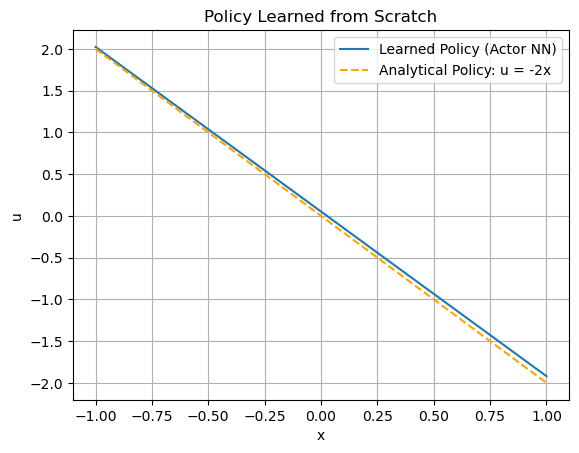

0.9977936148643494

In [42]:
x_test = np.linspace(-1, 1, 100).reshape(-1, 1).astype(np.float32)

# Predict using the trained actor
u_pred = actor_model.predict(x_test, verbose=0)

# Define correct analytical policy
u_analytical = -2 * x_test

# Plot
plt.plot(x_test, u_pred, label='Learned Policy (Actor NN)')
plt.plot(x_test, u_analytical, '--', label='Analytical Policy: u = -2x', color='orange')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Policy Learned from Scratch')
plt.grid()
plt.legend()
plt.show()
r2 = r2_score(u_analytical, u_pred)
r2